In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
import itertools
warnings.filterwarnings("ignore")

In [2]:
dfdate = pd.read_csv('dfdate1.csv')
dfdate['Date'] = pd.to_datetime(dfdate['Date'])
dfdate = dfdate.set_index('Date')
dfdate

,PM10,PM2.5,Wind speed,Wind dir,Temp,Rel hum,index,Unnamed: 8,Unnamed: 9
Date,,,,,,,,,
2013-10-08,21.090909,16.909091,1.413636,142.954545,26.263636,62.000000,2.979387,08-10-13,True
2013-10-09,56.208333,44.250000,0.729167,228.500000,27.833333,62.000000,2.948057,09-10-13,True
2013-10-10,37.208333,28.625000,0.891667,235.208333,29.295833,62.000000,2.813984,10-10-13,True
2013-10-11,50.500000,37.541667,0.737500,243.125000,28.900000,62.000000,3.219949,11-10-13,True
2013-10-12,89.458333,62.833333,0.850000,194.250000,30.141667,62.000000,1.746875,12-10-13,True
...,...,...,...,...,...,...,...,...,...
2020-09-26,29.079545,10.833333,0.976515,230.140152,29.499621,69.018939,4.020139,26-09-20,True
2020-09-27,27.030303,10.117424,1.160606,236.590909,29.044697,69.469697,3.645139,27-09-20,True
2020-09-28,26.694656,10.229008,0.631298,215.824428,26.720992,71.935114,4.273791,28-09-20,True


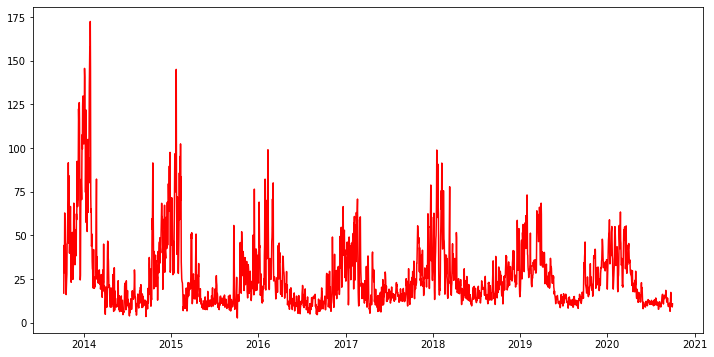

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(dfdate['PM2.5'],'r')

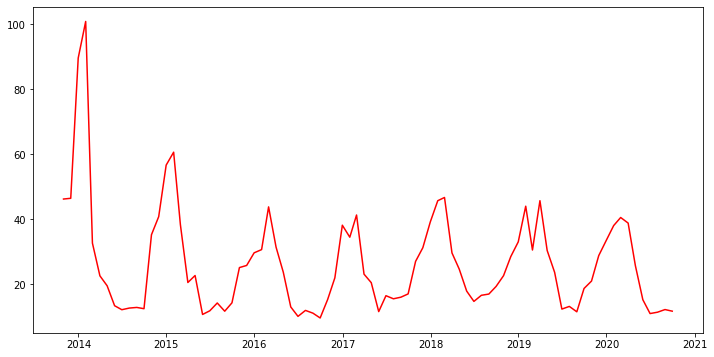

In [4]:
dfdate = dfdate.resample('M').mean()
plt.figure(figsize=(12,6))
plt.plot(dfdate['PM2.5'],'r')

In [5]:
train_size, valid_size, test_size = map(lambda r: int(r*dfdate.shape[0]), (0.6, 0.2, 0.2))
train, valid, test = dfdate.iloc[:train_size], dfdate.iloc[train_size:train_size+valid_size ], dfdate.iloc[train_size+valid_size: ]
#exog_columns = ['PM10',	'Wind speed',	'Wind dir',	'Temp',	'Rel hum',	'index']
exog_columns = ['PM10', 'Wind speed',	'Wind dir',	'Temp',	'Rel hum', 'index']

In [6]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_order = (0, 1, 1)
best_seasonal_order = (1, 1, 0, 12)


In [7]:
mod = SARIMAX(train['PM2.5'],
              exog=train[exog_columns],
              order=best_order,
              seasonal_order=best_seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False,
              frequency = "D")

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM10           0.5447      0.067      8.140      0.000       0.414       0.676
Wind speed    -0.3207      0.612     -0.524      0.600      -1.521       0.879
Wind dir      -0.0137      0.026     -0.524      0.600      -0.065       0.038
Temp          -0.3605      1.521     -0.237      0.813      -3.341       2.620
Rel hum        0.4964      0.924      0.537      0.591      -1.314       2.307
index         -0.3896      1.465     -0.266      0.790      -3.262       2.482
ma.L1         -1.0032     10.879     -0.092      0.927     -22.325      20.318
ar.S.L12       0.0129      0.148      0.087      0.931      -0.278       0.304
sigma2         5.3287     60.354      0.088      0.930    -112.963     123.621


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


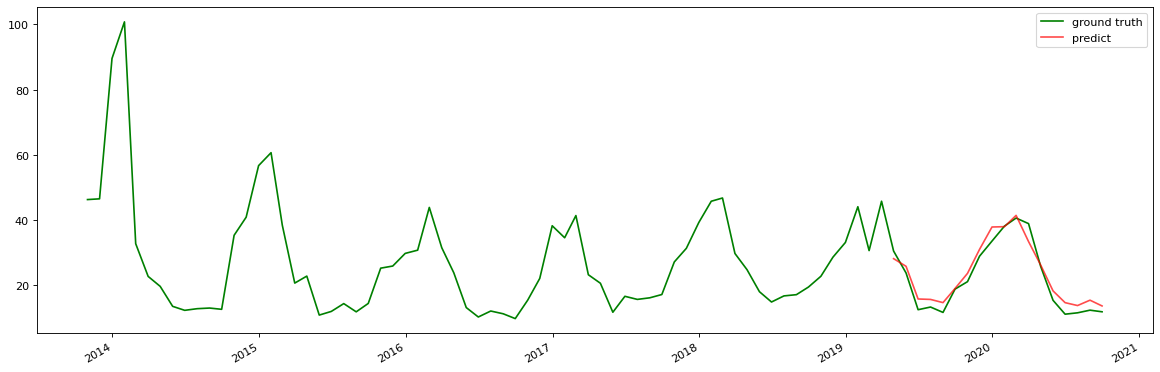

In [8]:
test_exog = pd.concat((valid[exog_columns], test[exog_columns]), axis=0)
pred = results.get_prediction(start=test.index[0], end=test.index[-1], exog=test_exog, dynamic=False)
pred_ci = pred.conf_int()

from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfdate['PM2.5'], color='g',label='ground truth')
pred.predicted_mean.plot(alpha=.7, color='r',label='predict')
plt.legend(loc="upper right")

plt.show()

In [9]:
mse = mean_squared_error(test['PM2.5'], pred.predicted_mean)
rmse = math.sqrt(mse)
print('Test on SARIMAX with RMSE: %f' % (rmse, ))

Test on SARIMAX with RMSE: 2.730941
